In [ ]:
! pip install faiss-gpu

In [ ]:
import numpy as np
from scipy import spatial
import faiss
import typing
from time import time
import matplotlib.pyplot as plt

## Helper Function

In [ ]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        distribution: str,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim))

In [ ]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [ ]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [ ]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [ ]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [ ]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [ ]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li>
 <li> optimized_exhaustive_search </li>
 <li> faiss_flatL2 </li>
</ol>

each one implements vector search with different levels of optimization. Your task is to compare the running time of these three methods.
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.

### Generate the following plots:
##### 1.1.1. Running time of the three methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
##### 1.1.2. Running time of the three methods as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 100000
* number of vectors in the query set: 1000

In [ ]:
#TODO: Write your code for 1.1.1 here
import gc

def measure_time(n_index_vectors, query_num, dim, k, dist, is_naive):
    index_vectors = generate_vectors(n_index_vectors, dim,dist)
    query_vectors = generate_vectors(query_num, dim, dist)

    naive_time = 0
    if is_naive:
      # naive exhaustive search
      start = time()
      naive_exhaustive_search(query_vectors, index_vectors, k)
      naive_time = time() - start

    # optimized exhaustive search
    start = time()
    optimized_exhaustive_search(query_vectors, index_vectors, k)
    optimized_time = time() - start

    # faiss search
    start = time()
    index = build_faiss_flatl2_index(index_vectors.astype('float32'), dim)
    faiss_search(query_vectors.astype('float32'), index, k)
    faiss_time = time() - start

    del index_vectors, query_vectors
    gc.collect()

    return naive_time, optimized_time, faiss_time

In [ ]:
# 1.1.1 Running time as a function of the number of vectors in the index

dims = 100
query_num = 1000

k = 1
index_sizes = range(2000,20001,2000)
100000
naive_times = []
optimized_times = []
faiss_times = []

for n_index_vectors in index_sizes:
    naive_time, optimized_time, faiss_time = measure_time(n_index_vectors, query_num, dims, k, 'maabada', True)
    naive_times.append(naive_time)
    optimized_times.append(optimized_time)
    faiss_times.append(faiss_time)

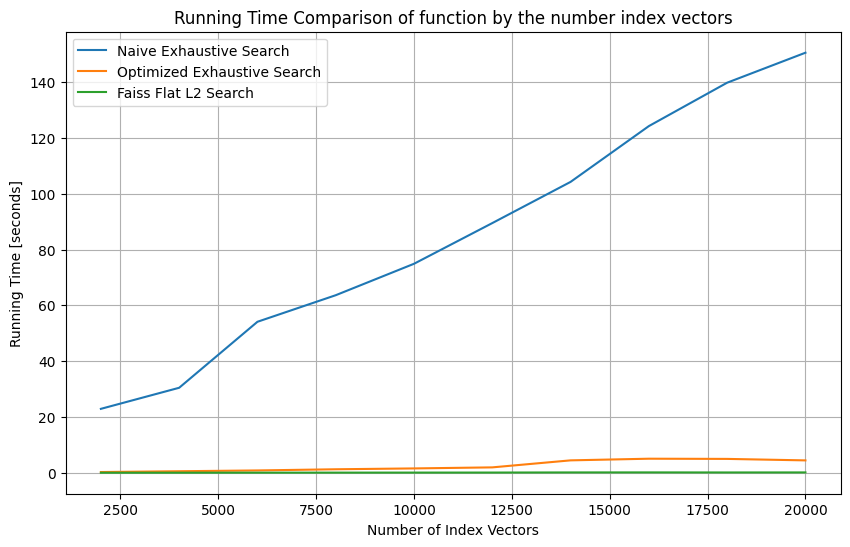

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(index_sizes, naive_times, label='Naive Exhaustive Search')
plt.plot(index_sizes, optimized_times, label='Optimized Exhaustive Search')
plt.plot(index_sizes, faiss_times, label='Faiss Flat L2 Search')
plt.title('Running Time Comparison of function by the number index vectors')
plt.xlabel('Number of Index Vectors')
plt.ylabel('Running Time [seconds]')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#TODO: Write your code for 1.1.2 here

'''
1.1.2:
a) No need to run naive_exhaustive_search but only the other two methods
b) Number of vectors in the query set=100 (instead of 1000)
'''

index_size = 100000
query_num = 100

k = 10
dim_sizes = range(100,1001,10)

# naive_times = []
optimized_times = []
faiss_times = []

for dim_i in dim_sizes:
    _, optimized_time, faiss_time = measure_time(index_size, query_num, dim_i, k, 'maabada', False)
    # naive_times.append(naive_time)
    optimized_times.append(optimized_time)
    faiss_times.append(faiss_time)

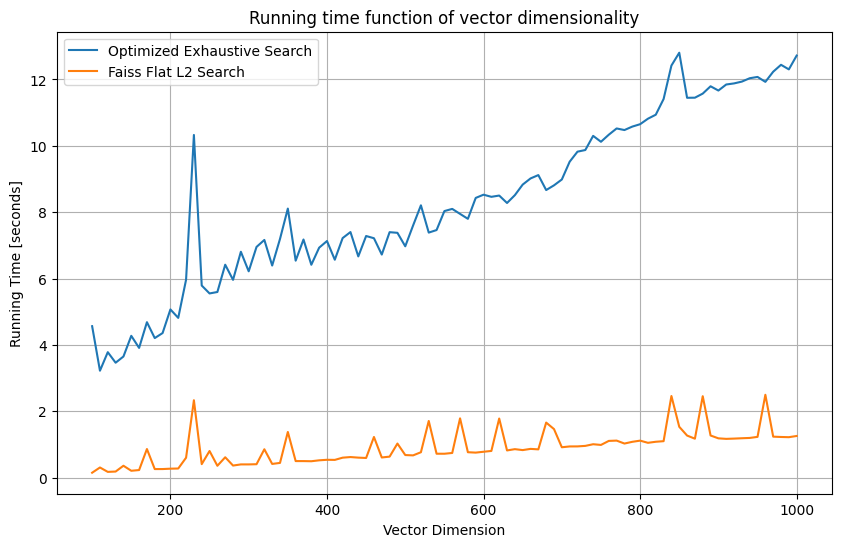

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(dim_sizes, optimized_times, label='Optimized Exhaustive Search')
plt.plot(dim_sizes, faiss_times, label='Faiss Flat L2 Search')
plt.title('Running time function of vector dimensionality')
plt.xlabel('Vector Dimension')
plt.ylabel('Running Time [seconds]')
plt.grid(True)
plt.legend()
plt.show()

# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.


In [ ]:
#TODO: Write your code for 1.2.1 here

def measure_lsh_time(n_index_vectors,query_num, dim, nbits, k, dist='maabada'):
    index_vectors = generate_vectors(n_index_vectors, dim, dist)
    query_vectors = generate_vectors(query_num, dim, dist)

    # faiss LSH index
    start = time()
    lsh_index = build_faiss_lsh_index(index_vectors.astype('float32'), dim, nbits)
    index_build_time = time() - start

    # faiss LSH search
    start = time()
    faiss_search(query_vectors.astype('float32'), lsh_index, k)
    search_time = time() - start

    total_time = index_build_time + search_time

    del index_vectors, query_vectors
    gc.collect()
    return total_time

In [ ]:
dims = 100
nbits = 500
query_num = 1000

k = 3
index_sizes = [100, 500, 1000, 5000, 10000, 100000, 1000000]
index_sizes = range(5000,100001,1000)
lsh_times = []
for n_index_vectors in index_sizes:
    lsh_time = measure_lsh_time(n_index_vectors,query_num, dims, nbits, k)
    lsh_times.append(lsh_time)

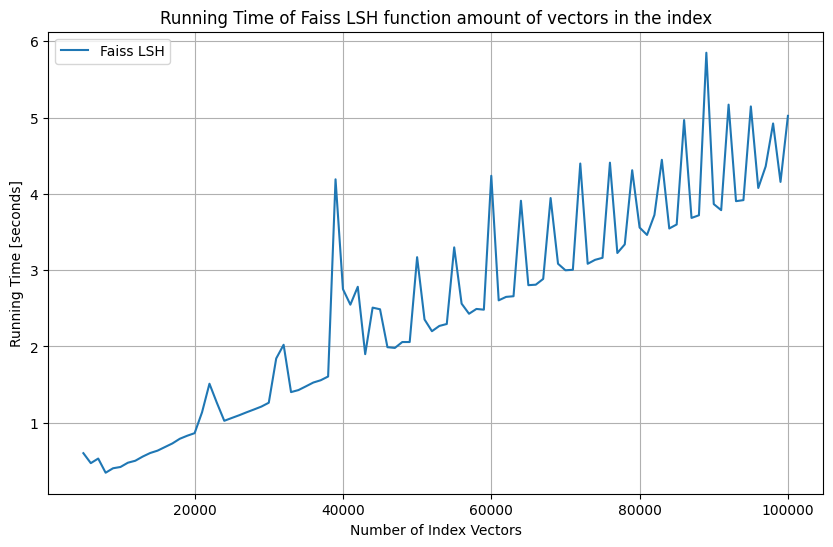

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(index_sizes, lsh_times, label='Faiss LSH')
plt.title('Running Time of Faiss LSH function amount of vectors in the index')
plt.xlabel('Number of Index Vectors')
plt.ylabel('Running Time [seconds]')
plt.grid(True)
plt.legend()
plt.show()

In [54]:
#TODO: Write your code for 1.2.2 here

dims = 100
query_num = 1000
num_index_vectors = 500000
k = 10

nbits_values = range(100,1001,100)

lsh_times = []

for nbits in nbits_values:
    lsh_time = measure_lsh_time(num_index_vectors,query_num, dims, nbits, k)
    lsh_times.append(lsh_time)

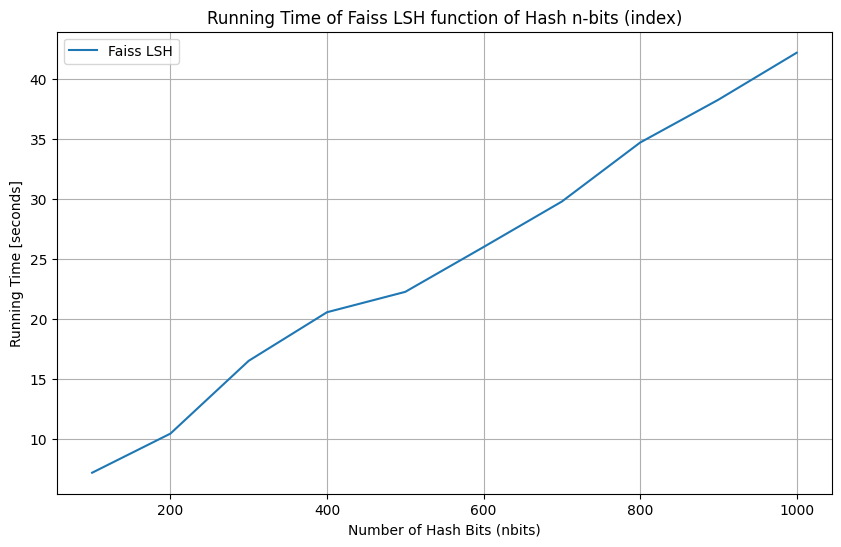

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(nbits_values, lsh_times, label='Faiss LSH')
plt.title('Running Time of Faiss LSH function of Hash n-bits (index)')
plt.xlabel('Number of Hash Bits (nbits)')
plt.ylabel('Running Time [seconds]')
plt.grid(True)
plt.legend()
plt.show()

In [57]:
#TODO: Write your code for 1.2.3 here

'''
1.2.3:
a) Number of vectors in the query set=100 (instead of 1000)
b)  Number of vectors in the index set=100000 (instead of 500000)
'''

dims = 100
query_num = 100
num_index_vectors = 100000
k = 10

nbits_values = range(100,1001,100)

recalls = []
index_vectors = generate_vectors(num_index_vectors, dims, 'maabada').astype('float32')
query_vectors = generate_vectors(query_num, dims, 'maabada').astype('float32')

# ground truth nearest neighbors
distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
nn_gt = np.argsort(distances, axis=1)[:, :k]

for nbits in nbits_values:
    # faiss LSH index
    lsh_index = build_faiss_lsh_index(index_vectors, dims, nbits)
    # faiss LSH search
    ann = faiss_search(query_vectors, lsh_index, k)
    # calculate recall@k
    recall = compute_recall_at_k(nn_gt, ann, k)
    recalls.append(recall)



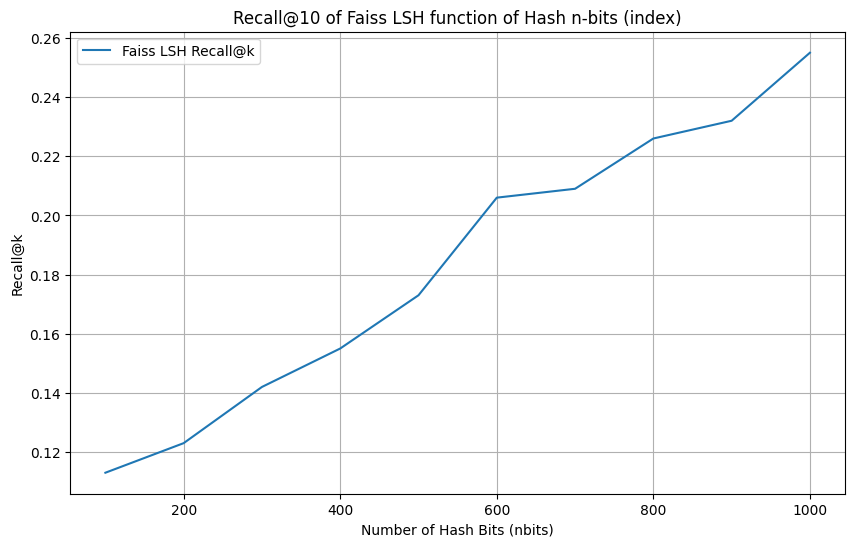

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(nbits_values, recalls, label='Faiss LSH Recall@k')
plt.title(f'Recall@{k} of Faiss LSH function of Hash n-bits (index)')
plt.xlabel('Number of Hash Bits (nbits)')
plt.ylabel('Recall@k')
plt.grid(True)
plt.legend()
plt.show()